## Implementation

#### Coding the architecture

In [1]:
GPT_CONFIG_124M = {
"vocab_size": 50257, # Vocabulary size
"context_length": 1024, # Context length
"emb_dim": 768, # Embedding dimension
"n_heads": 12, # Number of attention heads
"n_layers": 12, # Number of layers
"drop_rate": 0.1, # Dropout rate
"qkv_bias": False # Query-Key-Value bias
}

In [2]:
import torch
import torch.nn as nn

class DummyGPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.tok_embdgs = nn.Embedding(config["vocab_size"], config["emb_dim"])
        self.pos_embdgs = nn.Embedding(config["context_length"], config["emb_dim"])
        self.drop_embdgs = nn.Dropout(config["drop_rate"])
        
        # Transformer block placeholder
        self.transformer_block = nn.Sequential(*[DummyTransformerBlock(config) for _ in range (config["n_layers"])])


        # LayerNorm placeholder
        self.normalization_layer = DummyLayerNorm(config["emb_dim"])
        self.out_head = nn.Linear(config["emb_dim"], config["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, sequence_len = in_idx.shape
        tok_embdgs = self.tok_embdgs(in_idx)
        pos_embdgs = self.pos_embdgs(torch.arange(sequence_len, device=in_idx.device))
        return self.out_head(self.transformer_block(self.drop_embdgs(tok_embdgs + pos_embdgs)))
    
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
    
    def forward(self, x):
        return x
    
class DummyTransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
    
    def forward(self, x):
        return x
# 


In [3]:
import tiktoken

In [4]:
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
text1 = "I really need to go"
text2 = "Every day is a new"

batch.append(torch.tensor(tokenizer.encode(text1)))
batch.append(torch.tensor(tokenizer.encode(text2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[  40, 1107,  761,  284,  467],
        [6109, 1110,  318,  257,  649]])


In [5]:
torch.manual_seed(123)
model = DummyGPT(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 5, 50257])
tensor([[[ 0.7386, -1.2247, -0.3308,  ..., -0.2005,  0.3440, -0.2257],
         [-1.9745,  0.9537, -0.6724,  ..., -0.9423, -0.0838,  0.9865],
         [-0.8479,  1.4844,  0.0894,  ..., -0.0867,  0.6976, -0.7501],
         [-1.2166,  1.5133,  0.2305,  ...,  2.3118, -0.0691,  0.5523],
         [-0.4713, -0.8240,  1.2236,  ...,  0.3428, -0.0308, -1.6088]],

        [[-1.4299,  0.1282, -0.9106,  ..., -1.6346, -0.3399, -0.5688],
         [-0.3886,  0.2121, -0.4795,  ...,  0.0446,  0.2682,  1.3582],
         [ 0.6756, -0.5993, -0.4150,  ...,  0.3043,  0.1444, -0.1647],
         [ 0.3197, -0.7921, -0.2955,  ...,  1.8263,  0.0524, -0.0759],
         [-0.5478, -0.7816,  0.1229,  ..., -0.8491, -1.2927, -1.1232]]],
       grad_fn=<UnsafeViewBackward0>)


#### Normalizing activations with layer normalization

We implement layer normalization to improve stability of the neural network. We've to adjust the output (activation) of each layer such that the mean is 0 and the variance is 1 (unit variance). We apply layer normalization after before and after the multi-head attention module.

In [6]:
torch.manual_seed(123)
example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
# layer is a Linear layer followed by a non-linear activation layer ReLU (turns -ive vals into 0)

result = layer(example)
print(result)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [7]:
# Let's examine the mean and variance

mean = result.mean(dim=-1, keepdim=True)
variance =result.var(dim=-1, keepdim=True)
print("Mean:", mean)
print("Variance:", variance)

Mean: tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance: tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


`keepdim=True` ensures the output has the same shape as the input

`dim=-1` calculates the statistic at the last dimension, which is the column in a 2D tensor 

Now we'll apply the normalization layer to the layer outputs

In [8]:
normalized_result = (result - mean) / torch.sqrt(variance)
mean = normalized_result.mean(dim=-1, keepdim=True)
variance = normalized_result.var(dim=-1, keepdim=True)
print("Normalized output:", normalized_result)
print("Normalized Mean:", mean)
print("Normalized variance:", variance)

Normalized output: tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Normalized Mean: tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
Normalized variance: tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [9]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self, result):
        mean = result.mean(dim=-1, keepdim=True)
        variance = result.var(dim=-1, keepdim=True, unbiased = False)
        normalized_result = (result-mean) / torch.sqrt(variance+self.eps)
        return self.scale*normalized_result + self.shift

`self.eps` prevents division by zero from occuring

`unbiased=False` because when calculating the variance, we divide the variance formula by *n*. In Bessel's calculation, we divide it by *n-1* to adjust for bias in sample variance estimation, which results in a biased estimate. In LLM where the embedding size is very large, there's pretty much no difference between *n* and *n-1*. So we choose this approach to mimic GPT-2

In [10]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(example)
mean = out_ln.mean(dim=-1, keepdim=True)
variance = out_ln.var(dim=-1, keepdim=True, unbiased=False)
print("Mean:", mean)
print("Variance:", variance)

Mean: tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance: tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


#### Feed forward network with GELU activations

In addition to the ReLU, other activation functions are also used including the Gaussian Error Linear Unit (GELU) and Sigmoid-Weighted Linear Unity (SwiGLU) which offered better performance.

We'll use the following formula for GELU (which guess what was also used in GPT-2):

GELU(x) = 0.5 ⋅ x ⋅ (1 + tanh[√((2/π)) ⋅ (x + 0.044715 ⋅ x^3)])

In [11]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*(x+0.044715*torch.pow(x, 3))))

Let's see a comparison of ReLU and GELU

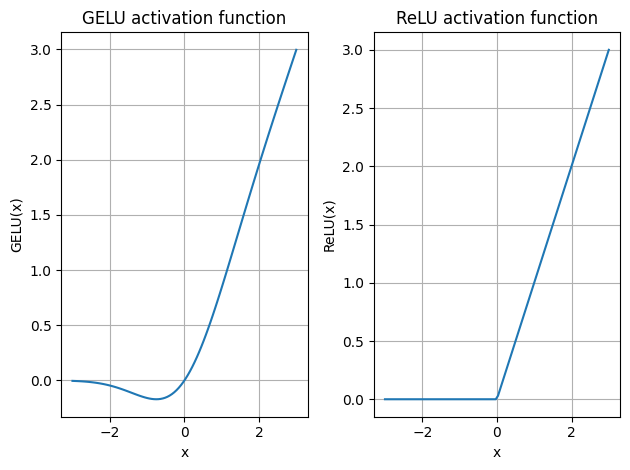

In [12]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
# plt.figure(figsize=)
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

As shown above, GELU is smoother than ReLU, which gives better optimization properties in training. Also since the negative x's have at least a small negative value, it means they can still contribute to the training process

In [13]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config["emb_dim"], 4*config["emb_dim"]),
            GELU(),
            nn.Linear(4*config["emb_dim"], config["emb_dim"])
        )

    def forward(self, x):
        return self.layers(x)
    
# 768 inputs are multiplied by 4, pass through a GELU activation, and then scaled back down to 4

In [14]:
fff = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2,3,768)     # 2 samples, 3 tokens each, 768 token embedding size
out = fff(x)
print(out.shape)

torch.Size([2, 3, 768])


#### Shortcut connections

Also called skip and residual connections. They help reduce vanishing gradients in backward propogation in deep neural networks.

In [15]:
class exampleDNN(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_out = layer(x)
            if self.use_shortcut and x.shape == layer_out.shape:
                x = x+ layer_out
            else:
                x = layer_out
        return x

In [16]:
def print_gradients(model, x):
    result = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss
    loss = nn.MSELoss()
    loss = loss(result, target)

    # Backward pass for gradient calculation
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [17]:
layer_sizes = [3, 3, 3, 3, 3, 1]  
sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = exampleDNN(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)


layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


In [18]:
torch.manual_seed(123)
model_with_shortcut = exampleDNN(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


As you can see above, all layers have greater gradient means n the model with shortcut connections. They help us avoid the vanishing gradient problem.

Now we will connect everything we've learned (layer normalization, GLEU activation, feed forward module and shortcut connections) together in the transformer block.

#### Connecting attention and linear layers in a transformer block

TRANSFORMER BLOCK TIMEEEEE

In [19]:
from utils import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(
            d_in=config["emb_dim"],
            d_out=config["emb_dim"],
            context_length=config["context_length"],
            dropout=config["drop_rate"], 
            num_heads=config["n_heads"], 
            qkv_bias = False
        )
        self.ff = FeedForward(config)
        self.ln1 = LayerNorm(config["emb_dim"])
        self.ln2 = LayerNorm(config["emb_dim"])
        self.drop_residual = nn.Dropout(config["drop_rate"])
    
    def forward(self, x):
        shortcut = x
        x = self.drop_residual(self.attention(self.ln1(x)))
        x = x + shortcut

        shortcut = x
        x = self.drop_residual(self.ff(self.ln2(x)))
        x = x + shortcut

        return x

We apply layer normalization before the self-attention and feed forward modules and dropout is applied afterwards to prevent overfitting. This is referred to as *Pre-Layer Normalization*. Applying layer normalization after these modules leads to worse training results.

In [20]:
# let's instantiate thissss
torch.manual_seed(123)
x = torch.rand(2,4,768)     # sample data
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

# This output is a context vector that captures information from the entire input sequence

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [21]:
class GPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.tok_embdgs = nn.Embedding(config["vocab_size"], config["emb_dim"])
        self.pos_embdgs = nn.Embedding(config["context_length"], config["emb_dim"])
        self.drop_embdgs = nn.Dropout(config["drop_rate"])
        
        # Transformer block placeholder
        self.transformer_block = nn.Sequential(*[TransformerBlock(config) for _ in range (config["n_layers"])])


        # LayerNorm placeholder
        self.normalization_layer = LayerNorm(config["emb_dim"])
        self.out_head = nn.Linear(config["emb_dim"], config["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, sequence_len = in_idx.shape
        tok_embdgs = self.tok_embdgs(in_idx)
        pos_embdgs = self.pos_embdgs(torch.arange(sequence_len, device=in_idx.device))
        return self.out_head(self.transformer_block(self.drop_embdgs(tok_embdgs + pos_embdgs)))

In [22]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[  40, 1107,  761,  284,  467],
        [6109, 1110,  318,  257,  649]])

Output shape: torch.Size([2, 5, 50257])
tensor([[[ 1.1811, -0.9943,  1.4607,  ..., -1.4232,  1.6930, -0.3630],
         [ 0.2031, -0.4011, -0.3955,  ..., -2.2422,  1.5223, -0.9798],
         [ 1.9821,  0.2836, -0.2966,  ...,  0.6840, -2.2303, -0.4332],
         [ 0.0753, -0.9597, -0.3279,  ..., -0.0139, -1.0697, -0.4507],
         [ 1.0822,  0.1422,  0.4437,  ...,  0.3806,  0.1684, -1.8770]],

        [[ 0.0075,  0.0860, -0.6750,  ...,  0.5740,  0.3693, -0.4557],
         [-0.1819, -0.4923, -0.0064,  ...,  1.4041, -0.6463,  1.0808],
         [ 2.1564, -1.3662, -0.2608,  ...,  1.2424, -0.4615, -0.4717],
         [-0.9807, -0.7722,  0.8481,  ...,  2.0625, -0.4811,  0.7142],
         [ 1.2490, -0.1926,  0.4750,  ...,  0.9583,  0.3179, -2.3591]]],
       grad_fn=<UnsafeViewBackward0>)


In [23]:
# We'll convert these 50257-dimensional vectors back into tokens but first calculate the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [24]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


In [25]:
# Generate text sequentially
def generate_text(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):             # iterate for a specific no. of tokens
        idx_cond = idx[:, -context_size:]       # crop to the current context
        with torch.no_grad():                   
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)  # convert logits into prob. dist.
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)   # identify highest value
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("Encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("Encoded tensor shape:", encoded_tensor.shape)

Encoded: [15496, 11, 314, 716]
Encoded tensor shape: torch.Size([1, 4])


In [26]:
model.eval()
out = generate_text(
    model=model,
    idx = encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [27]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue
